# converting signals into images, bin files(.npz)

このノートブックではディレクトリを指定して、その中にある生波形データ(.mat)を、一括して画像(.png)及びその値（.npz）に変換し保存するという処理を行っています。

## シミュレーションデータ変換  
 シミュレーションで生成した`.mat`のファイルを統一形式である`.npz`に変換します。以下は、フォルダを指定するとその配下のファイルをすべて一括で変換し、`/processed`ディレクトリに保存するという処理を行うものです。

In [38]:
from src import mat2npz_sim
import os
import glob

# Define input and output directories
# Define the case name as a variable for clarity and reusability
case_name = "case9"

# Define base data directory for clarity
base_data_dir = "/home/smatsubara/documents/airlift/data/simulation"

def convert_all_simulation_mat_to_npz(case_name, base_data_dir):
    """
    Convert all simulation .mat files in the specified case directory to .npz format.

    Parameters
    ----------
    case_name : str
        The name of the simulation case (e.g., "case5").
    base_data_dir : str
        The base directory where simulation data is stored.
    """
    # Define input directory for raw simulation signals (relative to base_data_dir and case_name)
    mat_dir = os.path.join(base_data_dir, f"rawsignal/{case_name}/data")

    # Define config file path (relative to base_data_dir and case_name)
    config_path = os.path.join(base_data_dir, f"rawsignal/{case_name}/config.json")

    # Define output directory for processed files (relative to base_data_dir and case_name)
    output_dir = os.path.join(base_data_dir, f"processed/{case_name}")
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    # Save a copy of the config.json file to the output directory for reference
    import shutil
    config_copy_path = os.path.join(output_dir, "config.json")
    shutil.copy2(config_path, config_copy_path)
    print(f"Copied config.json to: {config_copy_path}")

    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    mat_files_list = glob.glob(os.path.join(mat_dir, "*.mat"))
    for mat_file in mat_files_list:
        print(f"Processing: {mat_file}")
        mat2npz_sim(mat_file, config_path, output_dir)

# 関数の呼び出し例
convert_all_simulation_mat_to_npz(case_name, base_data_dir)




Created output directory: /home/smatsubara/documents/airlift/data/simulation/processed/case9
Copied config.json to: /home/smatsubara/documents/airlift/data/simulation/processed/case9/config.json
Processing: /home/smatsubara/documents/airlift/data/simulation/rawsignal/case9/data/solid_liquid_reflector10.mat
<KeysViewHDF5 ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']>
['Nt', 'Nx', 'Ny', 'Nz', 'dim', 'dt', 'dx', 'dxudxn', 'dxudxn_sgx', 'dy', 'dyudyn', 'dyudyn_sgy', 'dz', 'dzudzn', 'dzudzn_sgz', 'k', 'k_max', 'kx_max', 'kx_vec', 'ky_max', 'ky_vec', 'kz_max', 'kz_vec', 'nonuniform', 'xn_vec', 'xn_vec_sgx', 'yn_vec', 'yn_vec_sgy', 'zn_vec', 'zn_vec_sgz']
999999999.9999999
keys: ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
(50000,)
Processed data and metadata saved to: /home/smatsubara/documents/airlift/data/simulation/processed/case9/solid_liquid_reflector10_processed.npz
Processing: /home/smatsubara/documents/airlift/data/simulation

## 機械学習用データセット生成（シミュレーション）
　次に、変換した`.npz`のファイルに対応する目標変数となる値を`/config.json`を使って計算し、データセットとなる`x_train.npy`,`t_train.npy`を作成していきます。これらのiDの紐づけが狂うとすべての計算の意味がなくなってしまうので、最大限注意してください。  
また、実機への展開をスムーズにするために、最大値を用いてスケーリングしていることとに注して下さい。その他順序付けなど筆者は細心の注意を払って実装していますが、もし誤りがあればご指摘いただけると幸いです。


In [39]:
from src import calculate_gvf_and_signal,npz2png
import numpy as np
import math
import json
import glob
import os
#units are all mm


x_list = []
t_list = []

# Process all .npz files in the specified directory with the single config.json


def process_case_and_return_dataset(case_name, base_dir):
    """
    Process all .npz files in the specified case directory, extract signals and GVF,
    and return the resulting datasets for machine learning.

    Parameters
    ----------
    case_name : str
        The name of the case (e.g., "case6").
    base_dir : str
        The base directory where the processed case data is stored.

    Returns
    -------
    x_train : np.ndarray
        Array of input signals for machine learning.
    t_train : np.ndarray
        Array of target GVF values for machine learning.
    """
    import glob
    import os
    import numpy as np
    import json
    npz_dir = base_dir
    config_path = os.path.join(base_dir, "config.json")
    npz_files = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
    print(npz_files)
    x_list = []
    t_list = []

    for npz_path in npz_files:
        input_tmp, target_tmp = calculate_gvf_and_signal(config_path, npz_path)
        x_list.append(input_tmp)
        t_list.append(target_tmp)
    #print(len(x_list))
    #print(len(t_list))
    # Convert lists to numpy arrays for machine learning
    x_train = np.array(x_list)
    t_train = np.array(t_list)
    #print(x_train.shape)
    #print(t_train.shape)
    return x_train, t_train

# Process all cases in the processed directory and aggregate x_train and t_train

import glob
import os
import numpy as np

# Define the base directory containing all cases
processed_base_dir = "/home/smatsubara/documents/airlift/data/simulation/processed"
output_path = "/home/smatsubara/documents/airlift/data/simulation/dataset"

# Get all case directories (e.g., case5, case6, ...)
case_dirs = sorted([d for d in os.listdir(processed_base_dir) if os.path.isdir(os.path.join(processed_base_dir, d)) and d.startswith("case")])

x_train_list = []
t_train_list = []

for case_name in case_dirs:
    base_dir = os.path.join(processed_base_dir, case_name)
    print(f"Processing {case_name} in {base_dir}")
    x_tmp, t_tmp = process_case_and_return_dataset(case_name, base_dir)
    print(f"x_tmp shape: {x_tmp.shape}, t_tmp shape: {t_tmp.shape}")
    x_train_list.append(x_tmp)
    t_train_list.append(t_tmp)

# Concatenate all cases into single arrays
x_train = np.concatenate(x_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)
x_train = x_train/np.max(x_train)
print("Final x_train shape:", x_train.shape)
print("Final t_train shape:", t_train.shape)
np.save(os.path.join(output_path, "x_train.npy"), x_train)
np.save(os.path.join(output_path, "t_train.npy"), t_train)
#print(t_train)
npz_file_path = "/home/smatsubara/documents/airlift/data/sandbox/simulation/processed/case5/solid_liquid1_processed.npz"
output_folder_path = "/home/smatsubara/documents/airlift/data/visualize"
npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=True, pulse_index=0)


Processing case10 in /home/smatsubara/documents/airlift/data/simulation/processed/case10
['/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector10_processed.npz', '/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector1_processed.npz', '/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector2_processed.npz', '/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector3_processed.npz', '/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector4_processed.npz', '/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector5_processed.npz', '/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector6_processed.npz', '/home/smatsubara/documents/airlift/data/simulation/processed/case10/solid_liquid_reflector7_processed.npz', '/home/smatsubara/documents/airlift/d

## 実機データ変換  
実機データの`.mat`のファイルも、先ほどと同様に統一形式である`.npz`に変換します。同じく、`experiments/processed`に保存されるようにしています。

In [1]:
from src import mat2npz_exp


file_path = "/home/smatsubara/documents/airlift/data/experiments/rawsignal/P20241015-1037.mat"
output_dir = "/home/smatsubara/documents/airlift/data/experiments/processed"  # Change to your desired directory


# 関数を呼び出して実行
mat2npz_exp(
    file_path=file_path,
    output_dir=output_dir,
    start_time=0.0,
    duration=5.0,
    amplitude_threshold=2,
    window_width=0.1e-3,
    signal_key="TDX1"
)


Loading data...
Loading successful
Using device: cuda
Number of detected triggers: (14988,)
arranged_pulses.shape: (14988, 5208, 4)
inf
processed_data.shape: (14988, 2500, 4)
(14988, 1, 4) 0.15655577 3.4028235e+38
(14988, 2500, 4) -3.4028235e+38 3.4028235e+38
max_value: 1.0
['__header__', '__version__', '__globals__', 'Tstart', 'Tinterval', 'ExtraSamples', 'RequestedLength', 'Length', 'Version', 'TDX1', 'TDX2', 'TDX3', 'TDX1_enlarged']
signal points: (2500,)
Processed data and metadata saved to: /home/smatsubara/documents/airlift/data/experiments/processed/P20241015-1037_processed.npz


'/home/smatsubara/documents/airlift/data/experiments/processed/P20241015-1037_processed.npz'

In [3]:
from src import npz2png
npz_file_path = "/home/smatsubara/documents/airlift/data/experiments/processed/P20241015-1037_processed.npz"
output_folder_path = "/home/smatsubara/documents/airlift/data/visualize"
npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=True, pulse_index=0)

(14988, 2500, 4)
device: cuda
/home/smatsubara/documents/airlift/data/visualize/P20241015-1037_processed_0img.png


In [3]:
import numpy as np
from src import npz2png
npz_file_path = "/home/smatsubara/documents/airlift/data/experiments/processed/P20241015-1037_processed.npz"
output_folder_path = "/home/smatsubara/documents/airlift/data/visualize"
# Load the processed .npz file
npz_data = np.load(npz_file_path)
signal = npz_data["processed_data"]  # Shape: (num_pulses, num_points, num_channels)
fs = npz_data["fs"]
print(np.max(signal))
print(np.min(signal))
# Upsample the signal to 20 times the original number of points
from scipy.signal import resample

upsample_factor = 20
upsampled_signal = resample(signal, signal.shape[1] * upsample_factor, axis=1)

print(f"Original signal shape: {signal.shape}")
print(f"Upsampled signal shape: {upsampled_signal.shape}")

# Optionally, save the upsampled signal to a new .npz file
upsampled_save_path = npz_file_path.replace("_processed.npz", f"_upsampled_x{upsample_factor}.npz")
np.savez(
    upsampled_save_path,
    processed_data=upsampled_signal,
    fs=fs * upsample_factor,  # Update the sampling frequency accordingly
    original_keys=npz_data["original_keys"]
)
print(f"Upsampled data saved to: {upsampled_save_path}")
npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=True, pulse_index=0)

1.0
-1.4584837
Original signal shape: (14988, 2500, 4)
Upsampled signal shape: (14988, 50000, 4)
Upsampled data saved to: /home/smatsubara/documents/airlift/data/experiments/processed/P20241015-1037_upsampled_x20.npz
(14988, 2500, 4)
device: cuda
/home/smatsubara/documents/airlift/data/visualize/P20241015-1037_processed_0img.png


## 機械学習用データセット生成(実機)  
次に、変換した`.npz`のファイルに対応する目標変数となる値を`/target_variables.csv`を使って参照し、データセット`x_test.npy` `t_test.npy`を作成していきます。


## 参考：機械学習
では、簡単なモデルでこのデータセットを学習し、実機で性能を検証してみましょう。

tensor(1.)
torch.Size([80, 50000])
torch.Size([80, 1])


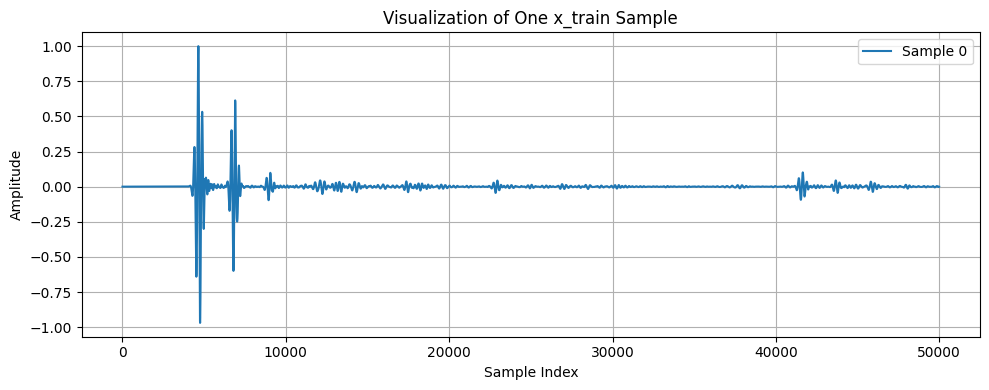

In [23]:
import numpy as np
import torch
x_train = np.load('/home/smatsubara/documents/airlift/data/simulation/dataset/x_train.npy')
t_train = np.load('/home/smatsubara/documents/airlift/data/simulation/dataset/t_train.npy')

x_train_tensor = torch.from_numpy(x_train).float()
t_train_tensor = torch.from_numpy(t_train).float()
if t_train_tensor.ndim == 1:
    t_train_tensor = t_train_tensor.unsqueeze(-1)
if x_train_tensor.ndim == 1:
    x_train_tensor = x_train_tensor.unsqueeze(-1)
print(torch.max(x_train_tensor))
print(x_train_tensor.shape)
print(t_train_tensor.shape)
#print(t_train_tensor)
import matplotlib.pyplot as plt

# English comment: Plot one sample from x_train for visualization
plt.figure(figsize=(10, 4))
plt.plot(x_train[0], label="Sample 0")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Visualization of One x_train Sample")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Basic GPyTorch regression tutorial with a simple sine function dataset

import math
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# English comment: Set device to GPU cuda:1 if available, otherwise CPU
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:1")
    print("Using device: cuda:1")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using device: cuda:0")
else:
    device = torch.device("cpu")
    print("Using device: cpu")

# Convert numpy arrays to torch tensors and move to device
# GPyTorch expects float32 tensors
t_train_tensor = torch.from_numpy(t_train).float().to(device)
x_train_tensor = torch.from_numpy(x_train).float().to(device)
print(t_train_tensor.shape)
print(x_train_tensor.shape)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check if x_train_tensor is 2D (samples, features) or needs reshaping for CNN
# For 1D CNN, input should be (batch, channels, length)
# If x_train_tensor is (N, L), reshape to (N, 1, L)
if x_train_tensor.ndim == 2:
    x_train_tensor_cnn = x_train_tensor.unsqueeze(1)  # (N, 1, L)
else:
    # If already 3D, use as is
    x_train_tensor_cnn = x_train_tensor

# If t_train_tensor is 2D, flatten to 1D for regression
if t_train_tensor.ndim > 1 and t_train_tensor.shape[1] == 1:
    t_train_tensor_cnn = t_train_tensor.squeeze(1)
else:
    t_train_tensor_cnn = t_train_tensor
print(x_train_tensor_cnn.shape)
print(t_train_tensor_cnn.shape)
# Create TensorDataset and DataLoader
from torch.utils.data import random_split

# 英語でコメント: Split the dataset into 75% for training and 25% for validation
dataset = TensorDataset(x_train_tensor_cnn, t_train_tensor_cnn)
total_size = len(dataset)
train_size = int(0.75 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size=8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define a simple 1D CNN model for regression with proper normalization
class SimpleCNN(nn.Module):
    def __init__(self, input_length):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=50, padding=1)
        # English comment: Use BatchNorm1d for normalization after the first convolution
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 8, kernel_size=50, padding=1)
        # English comment: Use BatchNorm1d for normalization after the second convolution
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        # x: (batch, 1, length)
        x = self.conv1(x)
        x = self.bn1(x)  # English comment: Apply batch normalization after the first convolution
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # English comment: Apply batch normalization after the second convolution
        x = self.relu2(x)
        x = self.pool(x)  # (batch, 8, 1)
        x = x.view(x.size(0), -1)  # (batch, 8)
        x = self.fc(x)  # (batch, 1)
        return x.squeeze(1)  # (batch,)

# Get input length from data
input_length = x_train_tensor_cnn.shape[2]

# Instantiate model, loss, and Aoptimizer, and move model to device
model = SimpleCNN(input_length).to(device)
# English comment: Define a custom loss function as the sum of (target - prediction) / target
def relative_sum_loss(pred, target):
    # English comment: Take the logarithm of the loss to avoid instability due to very small values
    epsilon = 1e-7  # Avoid division by zero and log(0)
    # 英語でコメント: Calculate the mean of the relative error instead of the sum
    loss = torch.mean(torch.abs(target - pred) / (target + epsilon))
    #loss = torch.log(torch.abs(loss) + epsilon)
    return loss

criterion = relative_sum_loss
# English comment: Initialize the Adam optimizer with a learning rate of 1e-4 for the model parameters
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

# Training loop

# Save the learning curve as an image
import matplotlib.pyplot as plt

loss_history = []

num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    loss_history.append(epoch_loss)
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
save_path="/home/smatsubara/documents/sandbox/psdata2matlab/tmp"
import os
# Plot and save the learning curve (logarithmic loss)
plt.figure()
# English comment: Plot the logarithm of the loss values for each epoch
plt.plot(range(1, num_epochs + 1), [np.log(l) for l in loss_history], marker='o')
plt.title('Learning Curve (Log Loss)')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.grid(True)
plt.savefig(os.path.join(save_path, 'learning_curve_log.png'))
plt.close()

# Plot and save the learning curve (raw loss)
plt.figure()
# English comment: Plot the raw loss values for each epoch
plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(os.path.join(save_path, 'learning_curve.png'))
plt.close()





Using device: cuda:1
torch.Size([80])
torch.Size([80, 50000])
torch.Size([80, 1, 50000])
torch.Size([80])
Epoch 10/400, Loss: 2.9137
Epoch 20/400, Loss: 1.7540
Epoch 30/400, Loss: 0.7506
Epoch 40/400, Loss: 0.3172
Epoch 50/400, Loss: 0.2887
Epoch 60/400, Loss: 0.2837
Epoch 70/400, Loss: 0.2800
Epoch 80/400, Loss: 0.2653
Epoch 90/400, Loss: 0.2915
Epoch 100/400, Loss: 0.2633
Epoch 110/400, Loss: 0.2698
Epoch 120/400, Loss: 0.2740
Epoch 130/400, Loss: 0.2467
Epoch 140/400, Loss: 0.2307
Epoch 150/400, Loss: 0.2311
Epoch 160/400, Loss: 0.2520
Epoch 170/400, Loss: 0.2313
Epoch 180/400, Loss: 0.2691
Epoch 190/400, Loss: 0.2574
Epoch 200/400, Loss: 0.2097
Epoch 210/400, Loss: 0.2219
Epoch 220/400, Loss: 0.2239
Epoch 230/400, Loss: 0.2510
Epoch 240/400, Loss: 0.2376
Epoch 250/400, Loss: 0.2448
Epoch 260/400, Loss: 0.2204
Epoch 270/400, Loss: 0.2937
Epoch 280/400, Loss: 0.2109
Epoch 290/400, Loss: 0.2059
Epoch 300/400, Loss: 0.2876
Epoch 310/400, Loss: 0.2502
Epoch 320/400, Loss: 0.2213
Epoch 3

### 推論  
学習したモデルを用いて、検証用のデータセットで性能を評価します。検証用の入力データをモデルに流し、どのような出力が得られるのかを確認しましょう。  
なおメモリが足りないので学習はcuda:1で、推論はcuda:0で行います。それゆえ、データ転送を行っていることに注意してください。

Validation predictions shape: torch.Size([20])
Validation targets shape: torch.Size([20])
tensor([0.0260, 0.0202, 0.0184, 0.0201, 0.0301, 0.0361, 0.0331, 0.0229, 0.0306,
        0.0209, 0.0330, 0.0255, 0.0099, 0.0278, 0.0109, 0.0220, 0.0254, 0.0213,
        0.0262, 0.0346])
Pearson correlation coefficient between predictions and actual values: 0.6279


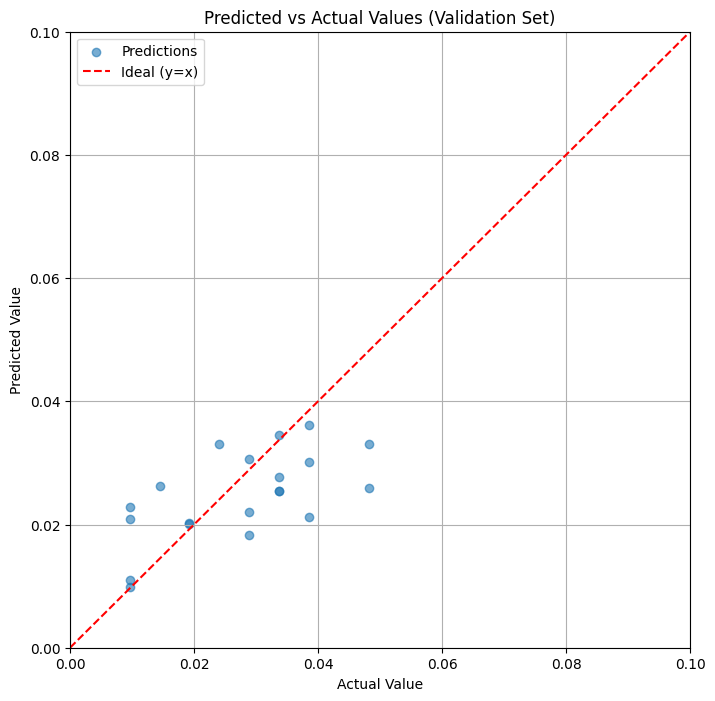

/tmp/ipykernel_1456799/1280856483.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


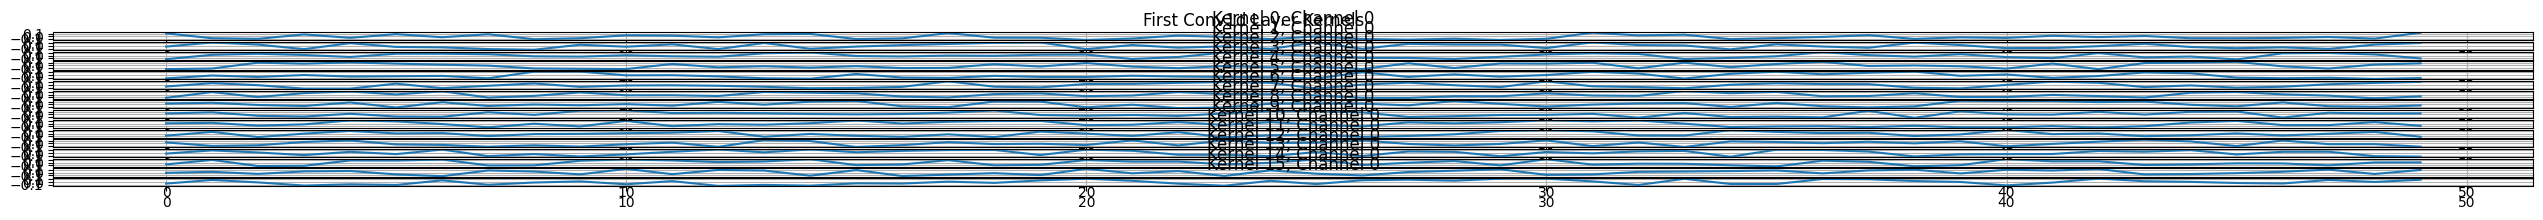

/home/smatsubara/documents/sandbox/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/home/smatsubara/documents/sandbox/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


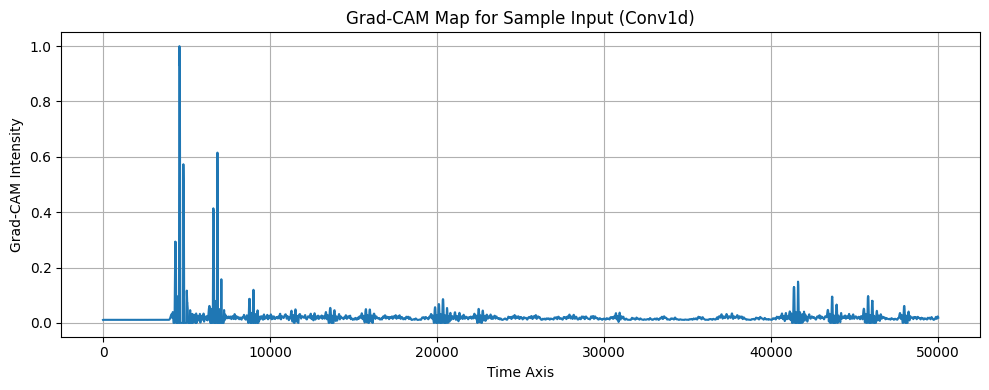

In [36]:
# English comment: Transfer the model trained on cuda:1 to cuda:0 for inference, and perform inference on cuda:0 using the previously created val_dataset
model = model.to('cuda:0')
model.eval()
val_predictions = []
val_targets = []
with torch.no_grad():
    for val_x, val_y in val_dataloader:
        # English comment: Send both val_x and val_y to cuda:0 for inference
        val_x = val_x.to('cuda:0')
        val_y = val_y.to('cuda:0')
        outputs = model(val_x)
        val_predictions.append(outputs.cpu())
        val_targets.append(val_y.cpu())
val_predictions = torch.cat(val_predictions, dim=0)
val_targets = torch.cat(val_targets, dim=0)
print("Validation predictions shape:", val_predictions.shape)
print("Validation targets shape:", val_targets.shape)
print(val_predictions)
# English comment: Plot the validation predictions and targets for comparison
import matplotlib.pyplot as plt

# English comment: Calculate the correlation coefficient between predicted and actual values
import numpy as np

# Convert tensors to numpy arrays
val_targets_np = val_targets.numpy().flatten()
val_predictions_np = val_predictions.numpy().flatten()

# English comment: Compute the Pearson correlation coefficient
correlation_matrix = np.corrcoef(val_targets_np, val_predictions_np)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Pearson correlation coefficient between predictions and actual values: {correlation_coefficient:.4f}")

# English comment: Plot predicted values (y-axis) against actual values (x-axis) in the xy-plane, with both axes limited to the range [0, 1]
plt.figure(figsize=(8, 8))
plt.scatter(val_targets_np, val_predictions_np, alpha=0.6, marker='o', label='Predictions')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y=x)')
plt.title('Predicted vs Actual Values (Validation Set)')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_path, 'val_pred_vs_actual_scatter.png'))
plt.show()
# English comment: Visualize the kernels (filters) of the first convolutional layer and compute Grad-CAM for a sample input

# --- Visualize kernels of the first convolutional layer (Conv1d version) ---
# English comment: Get the first Conv1d layer (assuming model has attribute 'conv1' or similar)
first_conv1d = None
for m in model.modules():
    if isinstance(m, torch.nn.Conv1d):
        first_conv1d = m
        break

if first_conv1d is not None:
    kernels = first_conv1d.weight.data.cpu().numpy()  # shape: (out_channels, in_channels, kernel_size)
    num_kernels = kernels.shape[0]
    num_channels = kernels.shape[1]
    kernel_size = kernels.shape[2]
    plt.figure(figsize=(num_kernels * 2, 2 * num_channels))
    for i in range(num_kernels):
        for j in range(num_channels):
            plt.subplot(num_kernels, num_channels, i * num_channels + j + 1)
            # English comment: Show the 1D kernel as a line plot
            plt.plot(kernels[i, j, :])
            plt.title(f'Kernel {i}, Channel {j}')
            plt.axis('tight')
            plt.grid(True)
    plt.suptitle('First Conv1d Layer Kernels')
    plt.tight_layout()
    plt.show()
else:
    print("No Conv1d layer found in the model.")

# --- Grad-CAM visualization for Conv1d ---
# English comment: Define a simple Grad-CAM function for the last Conv1d layer
class GradCAM1d:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            # English comment: For regression, use the output directly
            target = output.squeeze()
        else:
            target = output[:, class_idx]
        # English comment: For regression, backward on the sum
        if target.ndim > 0:
            target = target.sum()
        target.backward(retain_graph=True)
        gradients = self.gradients  # shape: (batch, channels, length)
        activations = self.activations  # shape: (batch, channels, length)
        # English comment: Global average pooling over the time dimension
        weights = gradients.mean(dim=2, keepdim=True)  # shape: (batch, channels, 1)
        grad_cam_map = (weights * activations).sum(dim=1, keepdim=True)  # shape: (batch, 1, length)
        grad_cam_map = torch.relu(grad_cam_map)
        grad_cam_map = torch.nn.functional.interpolate(grad_cam_map, size=input_tensor.shape[2], mode='linear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# English comment: Find the last Conv1d layer for Grad-CAM
target_layer_1d = None
for m in reversed(list(model.modules())):
    if isinstance(m, torch.nn.Conv1d):
        target_layer_1d = m
        break

if target_layer_1d is not None:
    grad_cam_1d = GradCAM1d(model, target_layer_1d)
    # English comment: Use a sample from validation set for Grad-CAM
    # val_x shape: (batch, channels, length)
    sample_input = val_x[0].unsqueeze(0).to('cuda:0')
    grad_cam_map = grad_cam_1d(sample_input)
    grad_cam_1d.remove_hooks()
    # English comment: Plot the Grad-CAM heatmap (1D)
    plt.figure(figsize=(10, 4))
    plt.plot(grad_cam_map)
    plt.title('Grad-CAM Map for Sample Input (Conv1d)')
    plt.xlabel('Time Axis')
    plt.ylabel('Grad-CAM Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No Conv1d layer found for Grad-CAM.")


tensor(1.3664)
tensor(1.3664)
torch.Size([14988, 1, 50000, 4])
torch.Size([14988, 50000, 4])
torch.Size([100, 1, 50000])
tensor(1.0336)


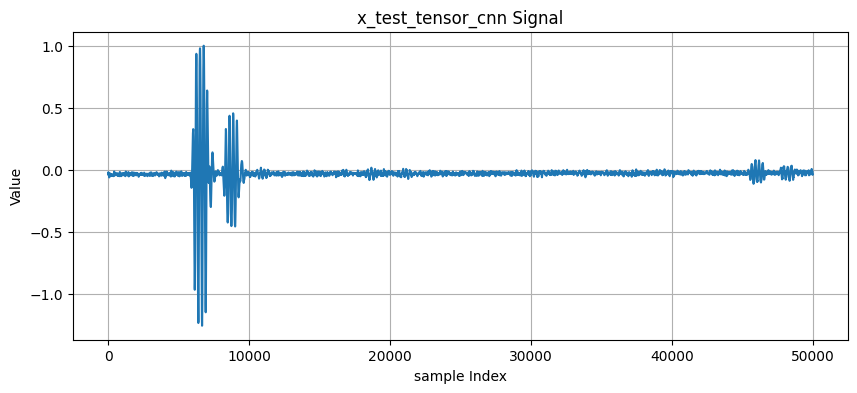

torch.Size([100])
tensor([-0.1133, -0.1145, -0.1128, -0.1296, -0.1235, -0.1221, -0.1234, -0.1219,
        -0.1284, -0.1225, -0.1109, -0.1170, -0.1200, -0.1214, -0.1250, -0.1219,
        -0.1234, -0.1207, -0.1223, -0.1216, -0.1205, -0.1213, -0.1353, -0.1153,
        -0.1157, -0.1129, -0.1300, -0.1150, -0.1056, -0.1117, -0.1112, -0.1173,
        -0.1155, -0.1215, -0.1246, -0.1236, -0.1112, -0.1104, -0.1067, -0.1153,
        -0.1139, -0.1149, -0.1180, -0.1176, -0.1165, -0.1090, -0.1187, -0.1149,
        -0.1254, -0.1267, -0.1217, -0.1143, -0.1122, -0.1082, -0.1084, -0.1109,
        -0.1149, -0.1101, -0.1030, -0.1157, -0.1096, -0.1140, -0.1160, -0.1234,
        -0.1297, -0.1225, -0.1196, -0.1151, -0.1110, -0.1193, -0.1197, -0.1205,
        -0.1205, -0.1044, -0.1105, -0.1129, -0.1112, -0.1110, -0.1167, -0.1204,
        -0.1114, -0.1212, -0.1247, -0.1217, -0.1212, -0.1182, -0.1174, -0.1157,
        -0.1094, -0.1148, -0.1184, -0.1250, -0.1277, -0.1244, -0.1328, -0.1229,
        -0.1152, -0.11

In [34]:
import numpy as np
import torch

path = "/home/smatsubara/documents/airlift/data/experiments/processed/P20241015-1037_upsampled_x20.npz"
output_folder_path = "/home/smatsubara/documents/sandbox/psdata2matlab/tmp"
x_test = np.load(path)["processed_data"]
x_test_tensor = torch.from_numpy(x_test).float()

print(torch.max(x_test_tensor))
x_test_tensor_all = x_test_tensor.unsqueeze(1)
print(torch.max(x_test_tensor_all))
print(x_test_tensor_all.shape)
a = 13000
x_test_tensor_cnn = x_test_tensor_all[a:a+100, :, :, 0]  # tdx1


print(x_test_tensor.shape)
print(x_test_tensor_cnn.shape)
print(torch.max(x_test_tensor_cnn))
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(x_test_tensor_cnn[40, 0, :].cpu().numpy())
plt.title("x_test_tensor_cnn Signal")
plt.xlabel("sample Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()
model.eval()
with torch.no_grad():
    x_test_tensor_cnn = x_test_tensor_cnn.to('cuda:0')
    predictions = model(x_test_tensor_cnn)
    print(predictions.shape)
    print(predictions)
    print(torch.mean(predictions))
    
